In [1]:
import os, cv2
import numpy as np
import tensorflow as tf
from tensorflow.python import keras

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, AveragePooling2D, AvgPool2D, MaxPool2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, array_to_img, load_img
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir = '../content/car and truck/'

images = []
car_types = []
for car_type in ["car","truck"]:
    car_dir = data_dir + car_type
    car_files = [car_dir + '/' + filename for filename in os.listdir(car_dir)]
    #print(car_files)
    for filename in car_files:
        if filename.endswith('jpg'):
            try:
                images.append(cv2.resize(cv2.imread(filename), (224,224), interpolation=cv2.INTER_CUBIC))
                car_types.append(car_type)
            except Exception as e:
                print(str(e))
            
            
images = np.array(images)
car_types = np.array(car_types)

le = LabelEncoder()
car_types_encoded = le.fit_transform(car_types)
car_types_encoded_onehot = np_utils.to_categorical(car_types_encoded)

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [3]:
print(car_types_encoded_onehot)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [4]:
images, car_types, car_types_encoded = shuffle(images, car_types, car_types_encoded)
car_types_encoded.resize((images.shape[0],1))
print(car_types_encoded.shape)

(588, 1)


In [5]:
print(images.shape)

(588, 224, 224, 3)


In [6]:
car_types_encoded = car_types_encoded.reshape((images.shape[0],1))
car_types_2class = np.zeros((images.shape[0],2))
for i in range(images.shape[0]):
    if car_types_encoded[i][0] == 0:
        car_types_2class[i][0] = 1
    else:
        car_types_2class[i][1] = 1
#print(car_types_2class[1:100,:])
x_train, x_val, y_train, y_val = train_test_split(images, car_types_2class, test_size=0.2, random_state=0)
x_train = x_train / 255
x_val = x_val / 255

train_datagen  = ImageDataGenerator(rescale=1./255,
                                 horizontal_flip=True,
                                 validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(x_train,y_train,batch_size=32)
test_generator = test_datagen.flow(x_val,y_val,batch_size=32)

In [7]:
print(car_types_2class)

[[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]


# LeNet-5

In [8]:
import keras
import tensorflow as tf
keras.backend.clear_session()

In [9]:

classifier=Sequential()
classifier.add(Conv2D(filters=6,kernel_size=(5,5),strides=(1,1),activation='tanh',input_shape=(224, 224, 3)))
classifier.add(AveragePooling2D(pool_size=(2,2),strides=(2,2)))
classifier.add(Conv2D(filters=16,kernel_size=(5,5),strides=(1,1),activation='tanh'))
classifier.add(AveragePooling2D(pool_size=(2,2),strides=(2,2)))
classifier.add(Conv2D(filters=120,kernel_size=(5,5),strides=(1,1),activation='tanh'))
classifier.add(Flatten())
classifier.add(Dense(units=84,activation='tanh'))
classifier.add(Dense(units=2,activation='softmax'))

classifier.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adam')

"\nclassifier=Sequential()\nclassifier.add(Conv2D(filters=6,kernel_size=5,strides=(1,1),activation='sigmoid',input_shape=(224, 224, 3)))\nclassifier.add(AvgPool2D(pool_size=2, strides=2))\nclassifier.add(Conv2D(filters=16,kernel_size=5,activation='sigmoid'))\nclassifier.add(AvgPool2D(pool_size=2, strides=2))\nclassifier.add(Dense(120,activation='sigmoid'))\nclassifier.add(Flatten())\nclassifier.add(Dense(units=84,activation='sigmoid'))\nclassifier.add(Dense(units=2,activation='sigmoid'))\n\nclassifier.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adam')\n"

In [10]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 6)       456       
_________________________________________________________________
average_pooling2d (AveragePo (None, 110, 110, 6)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 106, 106, 16)      2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 53, 53, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 49, 49, 120)       48120     
_________________________________________________________________
flatten (Flatten)            (None, 288120)            0         
_________________________________________________________________
dense (Dense)                (None, 84)                2

In [11]:
nb_epoch = 20
history = classifier.fit_generator(train_generator,
                    epochs=nb_epoch,validation_data = test_generator)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
15/15 [==============================] - 2s 110ms/step - loss: 0.8253 - accuracy: 0.5213 - val_loss: 0.6902 - val_accuracy: 0.5424
Epoch 2/20
15/15 [==============================] - 1s 80ms/step - loss: 0.6935 - accuracy: 0.5383 - val_loss: 0.6836 - val_accuracy: 0.5847
Epoch 3/20
15/15 [==============================] - 1s 81ms/step - loss: 0.6898 - accuracy: 0.5447 - val_loss: 0.6757 - val_accuracy: 0.5424
Epoch 4/20
15/15 [==============================] - 1s 81ms/step - loss: 0.6541 - accuracy: 0.6064 - val_loss: 0.6832 - val_accuracy: 0.5424
Epoch 5/20
15/15 [==============================] - 1s 82ms/step - loss: 0.6349 - accuracy: 0.6638 - val_loss: 0.6961 - val_accuracy: 0.5508
Epoch 6/20
15/15 [==============================] - 1s 81ms/step - loss: 0.5973 - accuracy: 0.6830 - val_loss: 0.8371 - val_accuracy: 0.5000
Epoch 7/20
15/15 [==============================] - 1s 82ms/step - loss: 0.65

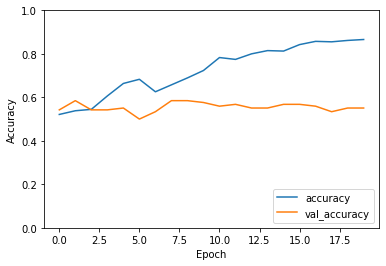

In [12]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')


In [13]:
classifier.evaluate_generator(generator=test_generator)

Instructions for updating:
Please use Model.evaluate, which supports generators.


[1.3996522426605225, 0.5508474707603455]

# VGG-16

In [14]:
import keras
import tensorflow as tf
keras.backend.clear_session()

In [15]:

model_vgg=Sequential()

model_vgg.add(Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation="relu",input_shape=(224,224,3)))
model_vgg.add(Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation="relu"))
model_vgg.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model_vgg.add(Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),activation="relu"))
model_vgg.add(Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),activation="relu"))
model_vgg.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

#model_vgg.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),activation="relu"))
model_vgg.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),activation="relu"))
model_vgg.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),activation="relu"))
model_vgg.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model_vgg.add(Conv2D(filters=512,kernel_size=(3,3),strides=(1,1),activation="relu"))
model_vgg.add(Conv2D(filters=512,kernel_size=(3,3),strides=(1,1),activation="relu"))
model_vgg.add(Conv2D(filters=512,kernel_size=(3,3),strides=(1,1),activation="relu"))
model_vgg.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model_vgg.add(Conv2D(filters=512,kernel_size=(3,3),strides=(1,1),activation="relu"))
model_vgg.add(Conv2D(filters=512,kernel_size=(3,3),strides=(1,1),activation="relu"))
model_vgg.add(Conv2D(filters=512,kernel_size=(3,3),strides=(1,1),activation="relu"))
model_vgg.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model_vgg.add(Flatten())
model_vgg.add(Dense(units=128,activation="relu"))
model_vgg.add(Dense(units=128,activation='relu'))
model_vgg.add(Dense(units=2,activation="softmax"))

opt = SGD(lr = 0.01, momentum = 0.9)
model_vgg.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adam')


"\ndef vgg_block(num_convs, num_channels):\n    blk = Sequential()\n    for _ in range(num_convs):\n        blk.add(Conv2D(num_channels, kernel_size=3,\n                           activation='relu'))\n    blk.add(MaxPool2D(pool_size=2, strides=2))\n    return blk\n\nconv_arch = ((1, 64), (2, 128), (3, 256), (3, 512), (3, 512))\ndef vgg(conv_arch):\n    model_vgg = Sequential()\n    model_vgg.add(Conv2D(64,kernel_size=3,activation='relu',input_shape=(224,224,3)))\n    # The convolutional part\n    for (num_convs, num_channels) in conv_arch:\n        model_vgg.add(vgg_block(num_convs, num_channels))\n    # The fully-connected part\n    model_vgg.add(Dense(4096, activation='relu')) \n    model_vgg.add(Dropout(0.5))\n    model_vgg.add(Dense(4096, activation='relu'))\n    model_vgg.add(Dropout(0.5))\n    model_vgg.add(Dense(2))\n    return model_vgg\n\nmodel_vgg = vgg(conv_arch)\nopt = SGD(lr = 0.01, momentum = 0.9)\nmodel_vgg.compile(loss='binary_crossentropy',metrics=['accuracy'],optimize

In [16]:
model_vgg.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 51, 51, 256)       2

In [17]:
nb_epoch = 20
history1 = model_vgg.fit_generator(train_generator,
                    epochs=nb_epoch,validation_data = test_generator)

Epoch 1/20
15/15 [==============================] - 15s 977ms/step - loss: 0.7796 - accuracy: 0.5191 - val_loss: 0.6939 - val_accuracy: 0.4831
Epoch 2/20
15/15 [==============================] - 9s 614ms/step - loss: 0.6936 - accuracy: 0.5000 - val_loss: 0.6937 - val_accuracy: 0.4831
Epoch 3/20
15/15 [==============================] - 9s 613ms/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6937 - val_accuracy: 0.4831
Epoch 4/20
15/15 [==============================] - 9s 610ms/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6937 - val_accuracy: 0.4831
Epoch 5/20
15/15 [==============================] - 9s 613ms/step - loss: 0.6937 - accuracy: 0.5000 - val_loss: 0.6939 - val_accuracy: 0.4831
Epoch 6/20
15/15 [==============================] - 9s 611ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6936 - val_accuracy: 0.4831
Epoch 7/20
15/15 [==============================] - 9s 612ms/step - loss: 0.6934 - accuracy: 0.4745 - val_loss: 0.6931 - val_accuracy: 0.5169
Epoch

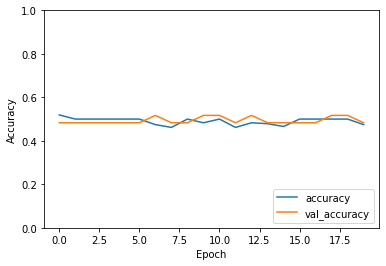

In [18]:
plt.plot(history1.history['accuracy'], label='accuracy')
plt.plot(history1.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [19]:
model_vgg.evaluate_generator(generator=test_generator)

[0.6932846307754517, 0.4830508530139923]

# AlexNet

In [20]:
import keras
import tensorflow as tf
keras.backend.clear_session()

In [21]:

model_alex=Sequential()

model_alex.add(Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),activation="relu",input_shape=(224,224,3)))
#model_alex.add(Conv2D(filters=64,kernel_size=(3,3),strides=(2,2),padding="same",activation="relu"))
model_alex.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

model_alex.add(Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),activation="relu"))
#model_alex.add(Conv2D(filters=128,kernel_size=(3,3),strides=(2,2),padding="same",activation="relu"))
model_alex.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

model_alex.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),activation="relu"))
model_alex.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),activation="relu"))
model_alex.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),activation="relu"))
model_alex.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

model_alex.add(Flatten())
model_alex.add(Dense(units=128,input_shape=(224*224*3,),activation='relu'))
model_alex.add(Dropout(0.5))
model_alex.add(Dense(units=128,activation='relu'))
model_alex.add(Dropout(0.5))
model_alex.add(Dense(units=64,activation='relu'))
model_alex.add(Dropout(0.5))
model_alex.add(Dense(units=2,activation='softmax'))

#opt = SGD(lr = 0.001, momentum = 0.9)
model_alex.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adam')


"\nmodel_alex = Sequential()\n# Here, we use a larger 11 x 11 window to capture objects. At the same time,\n# we use a stride of 4 to greatly reduce the height and width of the output.\n# Here, the number of output channels is much larger than that in LeNet\nmodel_alex.add(Conv2D(96, kernel_size=11, strides=4, activation='relu',input_shape=(224,224,3)))\nmodel_alex.add(MaxPool2D(pool_size=3, strides=2))\n        # Make the convolution window smaller, set padding to 2 for consistent\n        # height and width across the input and output, and increase the\n        # number of output channels\nmodel_alex.add(Conv2D(256, kernel_size=5, activation='relu'))\nmodel_alex.add(MaxPool2D(pool_size=3, strides=2))\n        # Use three successive convolutional layers and a smaller convolution\n        # window. Except for the final convolutional layer, the number of\n        # output channels is further increased. Pooling layers are not used to\n        # reduce the height and width of input after 

In [22]:
model_alex.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 384)         885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 384)         1327488   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 256)         8

In [23]:
nb_epoch = 20
history2 = model_alex.fit_generator(train_generator,
                    epochs=nb_epoch,validation_data = test_generator)

Epoch 1/20
15/15 [==============================] - 2s 108ms/step - loss: 0.6957 - accuracy: 0.5021 - val_loss: 0.6935 - val_accuracy: 0.4831
Epoch 2/20
15/15 [==============================] - 1s 60ms/step - loss: 0.6944 - accuracy: 0.4915 - val_loss: 0.6931 - val_accuracy: 0.5169
Epoch 3/20
15/15 [==============================] - 1s 57ms/step - loss: 0.6929 - accuracy: 0.5191 - val_loss: 0.6934 - val_accuracy: 0.4831
Epoch 4/20
15/15 [==============================] - 1s 59ms/step - loss: 0.6943 - accuracy: 0.5213 - val_loss: 0.6938 - val_accuracy: 0.4831
Epoch 5/20
15/15 [==============================] - 1s 58ms/step - loss: 0.6931 - accuracy: 0.5085 - val_loss: 0.6930 - val_accuracy: 0.5169
Epoch 6/20
15/15 [==============================] - 1s 59ms/step - loss: 0.6959 - accuracy: 0.4809 - val_loss: 0.6930 - val_accuracy: 0.5169
Epoch 7/20
15/15 [==============================] - 1s 61ms/step - loss: 0.6929 - accuracy: 0.5085 - val_loss: 0.6933 - val_accuracy: 0.4831
Epoch 8/20
1

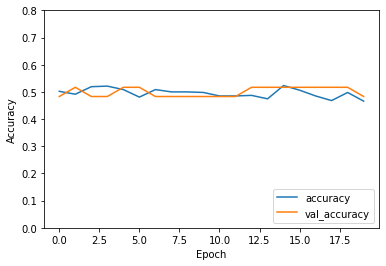

In [24]:
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 0.8])
plt.legend(loc='lower right')

In [25]:
model_alex.evaluate_generator(generator=test_generator)

[0.6933767795562744, 0.4830508530139923]